# PART 0. Importing, Merging per day , and Loading in of Data


In [1]:
#mount drive

Mounted at /content/drive


In [2]:
# this cell contains our library imports
import pandas as pd
import altair as alt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
#Load in transect lines - 1-2 is HK and 3-5 is MH
gdf1 = gpd.read_file("/content/drive/MyDrive/00 Living Lab/HK/hk_day1_viet.gpkg")
gdf2 = gpd.read_file("/content/drive/MyDrive/00 Living Lab/HK/hk_day2_viet.gpkg")
gdf3 = gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day1_viet.gpkg")
gdf4 = gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day2_viet.gpkg")
gdf5 = gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day3_viet.gpkg")
print("GDF1 CRS:", gdf1.crs)
print("GDF2 CRS:", gdf2.crs)
print("GDF3 CRS:", gdf3.crs)
print("GDF4 CRS:", gdf4.crs)
print("GDF5 CRS:", gdf5.crs)

GDF1 CRS: EPSG:32648
GDF2 CRS: EPSG:32648
GDF3 CRS: EPSG:32648
GDF4 CRS: EPSG:32648
GDF5 CRS: EPSG:32648


In [4]:
# merging
#df is Hang Kia
df = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))

#df2 is Mai Hich
df2 = gpd.GeoDataFrame(pd.concat([gdf3, gdf4, gdf5], ignore_index=True))

df2.head(2)

,commune,mapper,transect_id,date,organic_pr,plastic_pr,paper_pr,hazard_pr,glssmtl_pr,vol_waste,waste_diversity,length_m,geometry,spread_trs
0,Mai Hich,Gaia Fracchia,MH_0910_F24,0910,0,1,0,0,0,0,1,183.476118,"MULTILINESTRING ((501050.709 2277680.793, 5010...",NaN
1,Mai Hich,Hanh,MH_0910_F23,0910,1,1,1,0,0,3,3,192.609867,"MULTILINESTRING ((501166.199 2277783.547, 5011...",NaN


In [5]:
# computation of opendumping, trash_bins, and burning per 200m for Hang Kia

# 1. Load line layer (df already exists)
lines = df.copy()

# 2. Load & combine point layers
pts = pd.concat([
    gpd.read_file("/content/drive/MyDrive/00 Living Lab/HK/HK_day1_points.gpkg"),
    gpd.read_file("/content/drive/MyDrive/00 Living Lab/HK/HK_day2_points.gpkg")
], ignore_index=True)

# --------------------------------------------------------
# Clean column names
# --------------------------------------------------------
pts.columns = (
    pts.columns.str.strip().str.lower()
               .str.replace(" ", "_", regex=False)
               .str.replace("/", "_", regex=False)
)

lines.columns = lines.columns.str.strip().str.lower()

# Ensure correct key
pts = pts.rename(columns={"transect_id": "transect_id"})
lines = lines.rename(columns={"transect_id": "transect_id"})

# Keep only valid pts
pts = pts[pts["transect_id"].notna()].copy()
pts["what_did_you_observe"] = pts["what_did_you_observe"].str.strip().str.lower()

# --------------------------------------------------------
# Count three observation types
# --------------------------------------------------------
def count_obs(term):
    return (
        pts[pts["what_did_you_observe"] == term]
        .groupby("transect_id").size()
        .rename(f"{term}_count")
    )

open_counts   = count_obs("opendumping")
bins_counts   = count_obs("trash_bins")
burn_counts   = count_obs("burning")

# Combine counts
point_counts = (
    pd.concat([open_counts, bins_counts, burn_counts], axis=1)
      .fillna(0).astype(int)
      .reset_index()
)

# --------------------------------------------------------
# Join to lines + compute per 200m
# --------------------------------------------------------
out = lines.merge(point_counts, on="transect_id", how="left")

out.fillna({
    "opendumping_count": 0,
    "trash_bins_count": 0,
    "burning_count": 0
}, inplace=True)

out["length_m"] = pd.to_numeric(out["length_m"], errors="coerce")
out = out[out["length_m"] > 0].copy()

# NEW: scale for 200 meters
scale = out["length_m"] / 200

out["opendumping_per_200m"] = out["opendumping_count"] / scale
out["trash_bins_per_200m"]  = out["trash_bins_count"]  / scale
out["burning_per_200m"]     = out["burning_count"]     / scale

# --------------------------------------------------------
# NEW: reorder columns so transect_id is always second
# --------------------------------------------------------
cols = list(out.columns)

# Choose the first column reliably (your data shows "commune")
first_col = cols[0]

# Build new order
new_order = [first_col, "transect_id"] + [c for c in cols if c not in [first_col, "transect_id"]]

# Apply reorder
out = out[new_order]

# Final output
df = out

# creation of opendumping presence 0/1 field
df['opendumping_present'] = (df['opendumping_count'] > 0).astype(int)


df.head(2)


,commune,transect_id,date,length_m,mapper,organic_pr,plastic_pr,paper_pr,hazard_pr,glssmtl_pr,...,geometry,waste_diversity,waste_diversity,opendumping_count,trash_bins_count,burning_count,opendumping_per_200m,trash_bins_per_200m,burning_per_200m,opendumping_present
0,Hang Kia,HK_0915_1A,0915,187.4528,Lucas,0,1,0,0,0,...,MULTILINESTRING Z ((487933.428 2294160.78 1219...,1.0,NaN,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,Hang Kia,HK_0915_3A,0915,274.6523,Lucas,0,1,1,0,0,...,MULTILINESTRING Z ((488063.842 2294044.035 121...,2.0,NaN,0.0,1.0,0.0,0.0,0.728193,0.0,0


In [6]:
# --------------------------------------------------------
# computation of opendumping, trash_bins, and burning per 200m for Mai Hich
# --------------------------------------------------------

# 1. Load line layer (df2 already exists and is Mai Hich)
lines2 = df2.copy()

# 2. Load & combine point layers for Mai Hich

pts2 = pd.concat([
    gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day1_points.gpkg"),
    gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day2_points.gpkg"),
    gpd.read_file("/content/drive/MyDrive/00 Living Lab/MH/mh_day3_points.gpkg")
], ignore_index=True)

# --------------------------------------------------------
# Clean column names
# --------------------------------------------------------
pts2.columns = (
    pts2.columns.str.strip().str.lower()
                .str.replace(" ", "_", regex=False)
                .str.replace("/", "_", regex=False)
)

lines2.columns = lines2.columns.str.strip().str.lower()

# Ensure correct key
pts2 = pts2.rename(columns={"transect_id": "transect_id"})
lines2 = lines2.rename(columns={"transect_id": "transect_id"})

# Keep only valid pts
pts2 = pts2[pts2["transect_id"].notna()].copy()
pts2["what_did_you_observe"] = pts2["what_did_you_observe"].str.strip().str.lower()

# --------------------------------------------------------
# Count three observation types
# --------------------------------------------------------
def count_obs_mh(term):
    return (
        pts2[pts2["what_did_you_observe"] == term]
        .groupby("transect_id").size()
        .rename(f"{term}_count")
    )

open_counts_mh = count_obs_mh("opendumping")
bins_counts_mh = count_obs_mh("trash_bins")
burn_counts_mh = count_obs_mh("burning")

# Combine counts
point_counts_mh = (
    pd.concat([open_counts_mh, bins_counts_mh, burn_counts_mh], axis=1)
      .fillna(0).astype(int)
      .reset_index()
)

# --------------------------------------------------------
# Join to lines + compute per 200m
# --------------------------------------------------------
out2 = lines2.merge(point_counts_mh, on="transect_id", how="left")

out2.fillna({
    "opendumping_count": 0,
    "trash_bins_count": 0,
    "burning_count": 0
}, inplace=True)

out2["length_m"] = pd.to_numeric(out2["length_m"], errors="coerce")
out2 = out2[out2["length_m"] > 0].copy()

# scale for 200 meters
scale2 = out2["length_m"] / 200

out2["opendumping_per_200m"] = out2["opendumping_count"] / scale2
out2["trash_bins_per_200m"]  = out2["trash_bins_count"]  / scale2
out2["burning_per_200m"]     = out2["burning_count"]     / scale2

# --------------------------------------------------------
# Reorder columns so transect_id is always second
# --------------------------------------------------------
cols2 = list(out2.columns)

# First column should already be 'commune' in your schema
first_col2 = cols2[0]

new_order2 = [first_col2, "transect_id"] + [
    c for c in cols2 if c not in [first_col2, "transect_id"]
]

out2 = out2[new_order2]

# Final output: overwrite df2 with processed Mai Hich lines
df2 = out2

# creation of opendumping presence 0/1 field
df2["opendumping_present"] = (df2["opendumping_count"] > 0).astype(int)
# creation of burning presence 0/1 field
df2["burning"] = (df2["burning_count"] > 0).astype(int)

df2.head(2)
#

,commune,transect_id,mapper,date,organic_pr,plastic_pr,paper_pr,hazard_pr,glssmtl_pr,vol_waste,...,geometry,spread_trs,opendumping_count,trash_bins_count,burning_count,opendumping_per_200m,trash_bins_per_200m,burning_per_200m,opendumping_present,burning
0,Mai Hich,MH_0910_F24,Gaia Fracchia,0910,0,1,0,0,0,0,...,"MULTILINESTRING ((501050.709 2277680.793, 5010...",NaN,0.0,0.0,0.0,0.000000,0.0,0.0,0,0
1,Mai Hich,MH_0910_F23,Hanh,0910,1,1,1,0,0,3,...,"MULTILINESTRING ((501166.199 2277783.547, 5011...",NaN,1.0,0.0,0.0,1.038368,0.0,0.0,1,0


In [7]:
# Hang Kia Building Count and Density

lines = df.copy()

# load building polygon layer
build_poly = gpd.read_file("/content/drive/MyDrive/00 Living Lab/HK/Buildings_HK_final.gpkg")

# Convert buildings to centroids
build_pts = build_poly.copy()
build_pts["geometry"] = build_poly.geometry.centroid

# ----------------------------------------------------
# 4. CREATE A 25-METER ROAD INFLUENCE BUFFER
# ----------------------------------------------------
BUFFER_DIST = 25

buffer_gdf = lines[["transect_id", "geometry"]].copy()
buffer_gdf["geometry"] = buffer_gdf.geometry.buffer(BUFFER_DIST)

# ----------------------------------------------------
# 5. SPATIAL JOIN: COUNT BUILDINGS INSIDE EACH BUFFER
# ----------------------------------------------------
join = gpd.sjoin(
    build_pts[["geometry"]],
    buffer_gdf[["transect_id", "geometry"]],
    how="left",
    predicate="within"
)

# number of buildings within 25m per segment
bldg_count = (
    join.groupby("transect_id")
        .size()
        .rename("building_count")
        .to_frame()
)

# ----------------------------------------------------
# 6. MERGE COUNTS BACK TO THE TRANSECTS
# ----------------------------------------------------
lines = lines.merge(bldg_count, how="left", on="transect_id")
lines["building_count"] = lines["building_count"].fillna(0).astype(int)

# ----------------------------------------------------
# 7. COMPUTE BUILDING DENSITY PER 200 METERS
# ----------------------------------------------------
# ensure no zero-length segments
lines["length_m"] = lines["length_m"].replace(0, np.nan)

lines["building_density_per_200m"] = (
    lines["building_count"] / (lines["length_m"] / 200)
).replace([np.inf, -np.inf], np.nan).fillna(0).round(6)

df = lines

# ----------------------------------------------------
# 8. OUTPUT
# ----------------------------------------------------
print("✅ Done. Added columns:")
print(" - building_count")
print(" - building_density_per_200m")

df[["transect_id", "length_m", "building_count", "building_density_per_200m"]].head()


✅ Done. Added columns:
 - building_count
 - building_density_per_200m


,transect_id,length_m,building_count,building_density_per_200m
0,HK_0915_1A,187.4528,16,17.070964
1,HK_0915_3A,274.6523,10,7.281934
2,HK_0915_4A,273.8209,26,18.990515
3,HK_0915_5A,312.9465,28,17.894432
4,HK_0915_6A,225.4098,23,20.407276


In [8]:
df = df.loc[:, ~df.columns.duplicated()].copy()

In [9]:
# MAI HICH – BUILDING COUNT & DENSITY (df2)
lines2 = df2.copy()

build_poly_mh = gpd.read_file(
    "/content/drive/MyDrive/00 Living Lab/MH/Buildings_MH_final.gpkg")


build_pts_mh = build_poly_mh.copy()
build_pts_mh["geometry"] = build_poly_mh.geometry.centroid

BUFFER_DIST = 25  # meters

buffer_gdf_mh = lines2[["transect_id", "geometry"]].copy()
buffer_gdf_mh["geometry"] = buffer_gdf_mh.geometry.buffer(BUFFER_DIST)

join_mh = gpd.sjoin(
    build_pts_mh[["geometry"]],
    buffer_gdf_mh[["transect_id", "geometry"]],
    how="left",
    predicate="within"
)

# number of buildings within 25m per segment (MAI HICH)
bldg_count_mh = (
    join_mh.groupby("transect_id")
           .size()
           .rename("building_count")
           .to_frame()
)

#merge back to mai hich transects
lines2 = lines2.merge(bldg_count_mh, how="left", on="transect_id")
lines2["building_count"] = lines2["building_count"].fillna(0).astype(int)

# ----------------------------------------------------
# 7. COMPUTE MAI HICH BUILDING DENSITY PER 200 METERS

lines2["length_m"] = lines2["length_m"].replace(0, np.nan)

lines2["building_density_per_200m"] = (
    lines2["building_count"] / (lines2["length_m"] / 200)
).replace([np.inf, -np.inf], np.nan).fillna(0).round(6)


# ----------------------------------------------------
# 8. OUTPUT
# ----------------------------------------------------
df2 = lines2.copy()

print("✅ Done. Added columns:")
print(" - building_count")
print(" - building_density_per_200m")

df2[["transect_id", "length_m", "building_count", "building_density_per_200m"]].head(5)

✅ Done. Added columns:
 - building_count
 - building_density_per_200m


,transect_id,length_m,building_count,building_density_per_200m
0,MH_0910_F24,183.476118,0,0.000000
1,MH_0910_F23,192.609867,0,0.000000
2,MH_0910_F22,192.949305,20,20.730834
3,MH_0910_20,360.408833,2,1.109851
4,MH_0910_19,482.333924,23,9.536961


In [10]:
waste_type_cols = [
    "organic_pr",
    "plastic_pr",
    "paper_pr",
    "hazard_pr",
    "glssmtl_pr"]

df  = df.drop(columns=["waste_diversity"],  errors="ignore")
df2 = df2.drop(columns=["waste_diversity"], errors="ignore")

df["waste_diversity"]  = df[waste_type_cols].sum(axis=1)
df2["waste_diversity"] = df2[waste_type_cols].sum(axis=1)


if "notes" not in df2.columns:
    df2["notes"] = None


df2 = df2[df.columns.tolist()]

# 5. Merge into FULL

full = gpd.GeoDataFrame(
    pd.concat([df, df2], ignore_index=True),
    crs=df.crs
)

full.head(4)

,commune,transect_id,date,length_m,mapper,organic_pr,plastic_pr,paper_pr,hazard_pr,glssmtl_pr,...,opendumping_count,trash_bins_count,burning_count,opendumping_per_200m,trash_bins_per_200m,burning_per_200m,opendumping_present,building_count,building_density_per_200m,waste_diversity
0,Hang Kia,HK_0915_1A,0915,187.4528,Lucas,0,1,0,0,0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,16,17.070964,1
1,Hang Kia,HK_0915_3A,0915,274.6523,Lucas,0,1,1,0,0,...,0.0,1.0,0.0,0.000000,0.728193,0.000000,0,10,7.281934,2
2,Hang Kia,HK_0915_4A,0915,273.8209,Lucas,1,1,1,0,0,...,1.0,1.0,0.0,0.730404,0.730404,0.000000,1,26,18.990515,3
3,Hang Kia,HK_0915_5A,0915,312.9465,Lucas,0,1,1,0,0,...,0.0,0.0,2.0,0.000000,0.000000,1.278174,0,28,17.894432,2


In [11]:
full.columns.tolist()

['commune',
 'transect_id',
 'date',
 'length_m',
 'mapper',
 'organic_pr',
 'plastic_pr',
 'paper_pr',
 'hazard_pr',
 'glssmtl_pr',
 'spread_trs',
 'vol_waste',
 'burning',
 'notes',
 'geometry',
 'opendumping_count',
 'trash_bins_count',
 'burning_count',
 'opendumping_per_200m',
 'trash_bins_per_200m',
 'burning_per_200m',
 'opendumping_present',
 'building_count',
 'building_density_per_200m',
 'waste_diversity']

In [12]:
output_path = "LLfinaltransects.gpkg"
full.to_file(output_path, driver="GPKG")

In [13]:
x_output_path = "LL_final_transects.xlsx"
full.to_excel(x_output_path, index=False)

# 🪜 1.1 Transect Overview

In [14]:
#summary Table

metrics = [
    "Number of transects",
    "Total transect length (m)",
    "Mean transect length (m)",
    "Median transect length (m)",
    "Minimum transect length (m)",
    "Maximum transect length (m)",
]

summary_dict = {}

for commune_name, sub in full.groupby("commune"):
    sub = sub.dropna(subset=["length_m"])
    summary_dict[commune_name] = [
        len(sub),
        round(sub["length_m"].sum(), 2),
        round(sub["length_m"].mean(), 2),
        round(sub["length_m"].median(), 2),
        round(sub["length_m"].min(), 2),
        round(sub["length_m"].max(), 2),
    ]

summary_table = pd.DataFrame(summary_dict, index=metrics).reset_index()
summary_table = summary_table.rename(columns={"index": "Metric"})

summary_table

,Metric,Hang Kia,Mai Hich
0,Number of transects,51.00,117.00
1,Total transect length (m),18017.26,57064.04
2,Mean transect length (m),353.28,487.73
3,Median transect length (m),280.57,494.94
4,Minimum transect length (m),76.95,155.29
5,Maximum transect length (m),857.53,1475.27


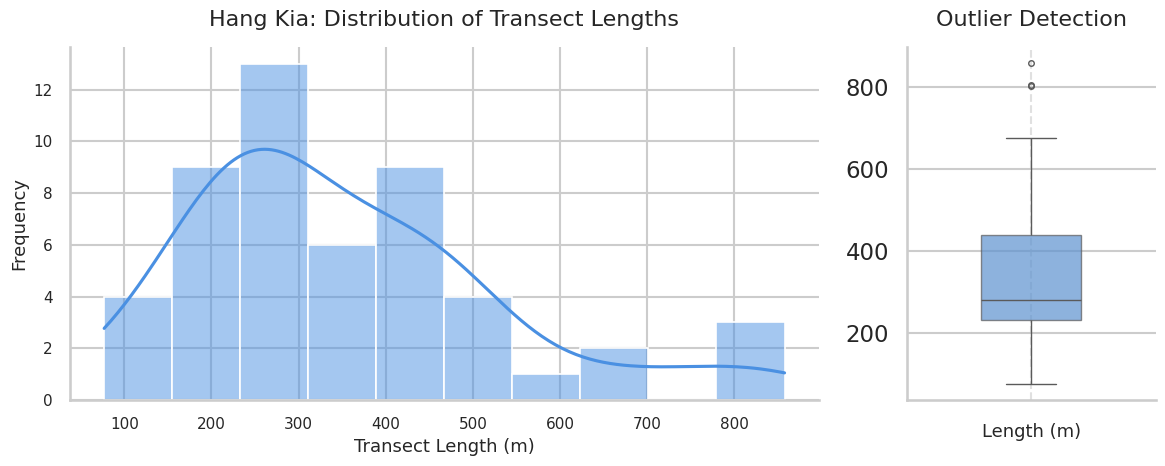

In [15]:
# Creation of histogram with KDE (line) to show shape of the distribution

sns.set(style="whitegrid", context="talk")
fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})

sns.histplot(
    df['length_m'],
    bins=10,
    kde=True,
    color='#4A90E2',
    edgecolor='white',
    linewidth=1.2,
    ax=ax[0]
)
ax[0].set_title("Hang Kia: Distribution of Transect Lengths", fontsize=16, pad=15)
ax[0].set_xlabel("Transect Length (m)", fontsize=13)
ax[0].set_ylabel("Frequency", fontsize=13)
ax[0].tick_params(axis='both', labelsize=11)

# Boxplot beside it (horizontal)
sns.boxplot(
    y=df['length_m'],
    color='#4A90E2',
    width=0.4,
    fliersize=4,
    boxprops=dict(alpha=0.7),
    ax=ax[1]
)
ax[1].set_title("Outlier Detection", fontsize=16, pad=15)
ax[1].set_ylabel("")  # hide redundant label
ax[1].set_xlabel("Length (m)", fontsize=13)
ax[1].tick_params(axis='x', labelsize=11)
ax[1].grid(axis='x', linestyle='--', alpha=0.6)

# Overall layout
plt.tight_layout()
sns.despine()
#plt.savefig("transect_length_distribution.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()

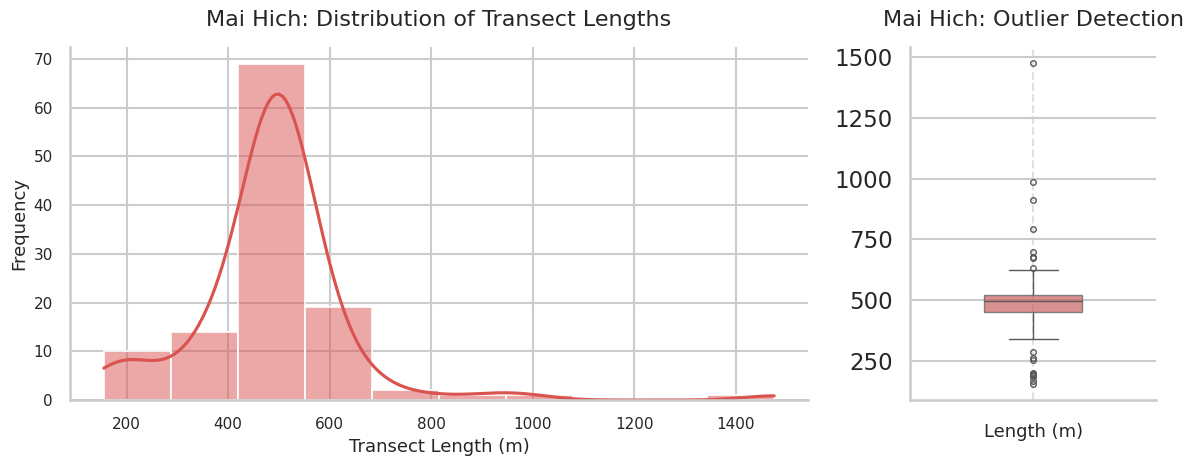

In [16]:
# Mai Hich version (df2) with red color
sns.set(style="whitegrid", context="talk")
fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})

# Histogram + KDE
sns.histplot(
    df2['length_m'],
    bins=10,
    kde=True,
    color='#D9534F',    # RED for Mai Hich
    edgecolor='white',
    linewidth=1.2,
    ax=ax[0]
)
ax[0].set_title("Mai Hich: Distribution of Transect Lengths", fontsize=16, pad=15)
ax[0].set_xlabel("Transect Length (m)", fontsize=13)
ax[0].set_ylabel("Frequency", fontsize=13)
ax[0].tick_params(axis='both', labelsize=11)

# Boxplot
sns.boxplot(
    y=df2['length_m'],
    color='#D9534F',    # RED for Mai Hich
    width=0.4,
    fliersize=4,
    boxprops=dict(alpha=0.7),
    ax=ax[1]
)
ax[1].set_title("Mai Hich: Outlier Detection", fontsize=16, pad=15)
ax[1].set_ylabel("")  # hide redundant label
ax[1].set_xlabel("Length (m)", fontsize=13)
ax[1].tick_params(axis='x', labelsize=11)
ax[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
sns.despine()
plt.show()


# 🪜 1.2 Waste Scores Overview - Waste Volume, Waste Spread, Waste Type and Diversity, Burning Evidence, and Dumping Evidence in Transects

### Waste Volume

In [17]:
#waste buildup using vol_waste

tmp = full.copy()

# make sure length_m is numeric
tmp["length_m"] = pd.to_numeric(tmp["length_m"], errors="coerce")

# 1. summarize per vol_waste × commune
summary = (
    tmp
    .groupby(["vol_waste", "commune"], as_index=False)
    .agg(
        Count=("length_m", "size"),
        Total_Length_m=("length_m", "sum")
    )
)

# 2. percent of each commune's total transect length
summary["Percent_of_Commune_Length"] = (
    summary["Total_Length_m"]
    / summary.groupby("commune")["Total_Length_m"].transform("sum")
    * 100
).round(4)

# 3. nice rounding + sorting
summary["Total_Length_m"] = summary["Total_Length_m"].round(4)
summary = summary.sort_values(["vol_waste", "commune"]).reset_index(drop=True)

summary


,vol_waste,commune,Count,Total_Length_m,Percent_of_Commune_Length
0,0,Hang Kia,4,1501.6687,8.3346
1,0,Mai Hich,13,5054.4164,8.8574
2,1,Hang Kia,32,11607.5851,64.4248
3,1,Mai Hich,80,38739.4925,67.8878
4,3,Hang Kia,13,4577.6957,25.4073
5,3,Mai Hich,21,11669.3714,20.4496
6,5,Hang Kia,2,330.3127,1.8333
7,5,Mai Hich,3,1600.7557,2.8052


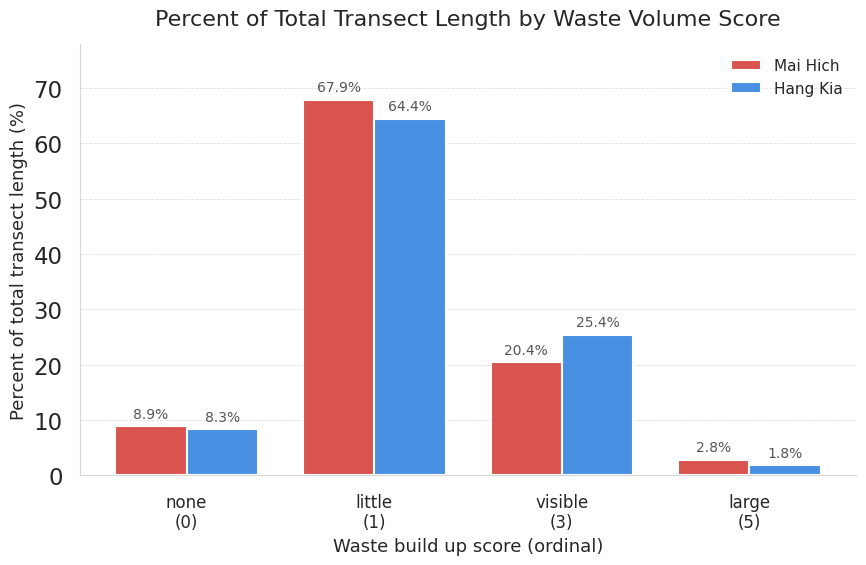

In [47]:
sns.set(style="whitegrid", context="talk")

# ---------------------------------------------------
# 1. PREP DATA
# ---------------------------------------------------
ordered_scores = sorted(summary["vol_waste"].unique())

hk = summary[summary["commune"] == "Hang Kia"].set_index("vol_waste")
mh = summary[summary["commune"] == "Mai Hich"].set_index("vol_waste")

hk_perc = hk.loc[ordered_scores]["Percent_of_Commune_Length"].fillna(0)
mh_perc = mh.loc[ordered_scores]["Percent_of_Commune_Length"].fillna(0)

x = np.arange(len(ordered_scores))
width = 0.38

# ---------------------------------------------------
# 2. COLORS
# ---------------------------------------------------
mh_red = "#D9534F"
hk_blue = "#4A90E2"

# ---------------------------------------------------
# 3. FIGURE
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))

bars_mh = ax.bar(
    x - width/2, mh_perc, width=width, color=mh_red, label="Mai Hich", zorder=3
)
bars_hk = ax.bar(
    x + width/2, hk_perc, width=width, color=hk_blue, label="Hang Kia", zorder=3
)

# ---------------------------------------------------
# 4. LABELS + TITLES (IMPROVED, CLEAN)
# ---------------------------------------------------
label_map = {
    0: "none\n(0)",
    1: "little\n(1)",
    3: "visible\n(3)",
    5: "large\n(5)",
}

ax.set_xticks(x)
ax.set_xticklabels(
    [label_map.get(v, str(v)) for v in ordered_scores],
    fontsize=12,
)

ax.set_xlabel("Waste build up score (ordinal)", fontsize=13)
ax.set_ylabel("Percent of total transect length (%)", fontsize=13)
ax.set_title(
    "Percent of Total Transect Length by Waste Volume Score",
    fontsize=16,
    pad=14,
)

upper = max(np.nanmax(hk_perc), np.nanmax(mh_perc))
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 5. GRID + SPINES + LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 6. ANNOTATIONS
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + upper * 0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555",
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 7. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


### Waste Spread

In [19]:
import pandas as pd

# starting point: full has ['commune', 'spread_trs', 'length_m', ...]

tmp = full.copy()

# ensure numeric
tmp["length_m"] = pd.to_numeric(tmp["length_m"], errors="coerce")

# ----------------------------------------
# 1. summarize per commune × spread_trs
# ----------------------------------------
spread_summary = (
    tmp
    .groupby(["spread_trs", "commune"], as_index=False)
    .agg(
        Count=("length_m", "size"),
        Total_Length_m=("length_m", "sum")
    )
)

# ----------------------------------------
# 2. percent of each commune’s total length
# ----------------------------------------
spread_summary["Percent_of_Commune_Length"] = (
    spread_summary["Total_Length_m"]
    / spread_summary.groupby("commune")["Total_Length_m"].transform("sum")
    * 100
).round(1)

# ----------------------------------------
# 3. rounding + sorting
# ----------------------------------------
spread_summary["Total_Length_m"] = spread_summary["Total_Length_m"].round(2)
spread_summary = spread_summary.sort_values(["spread_trs", "commune"]).reset_index(drop=True)

spread_summary


,spread_trs,commune,Count,Total_Length_m,Percent_of_Commune_Length
0,0.0,Mai Hich,2,769.19,1.7
1,1.0,Hang Kia,8,3157.88,17.5
2,1.0,Mai Hich,15,7405.55,16.5
3,2.0,Hang Kia,36,12497.49,69.4
4,2.0,Mai Hich,54,27991.71,62.5
5,3.0,Hang Kia,1,176.87,1.0
6,3.0,Mai Hich,8,3923.46,8.8
7,5.0,Hang Kia,6,2185.02,12.1
8,5.0,Mai Hich,8,4702.86,10.5


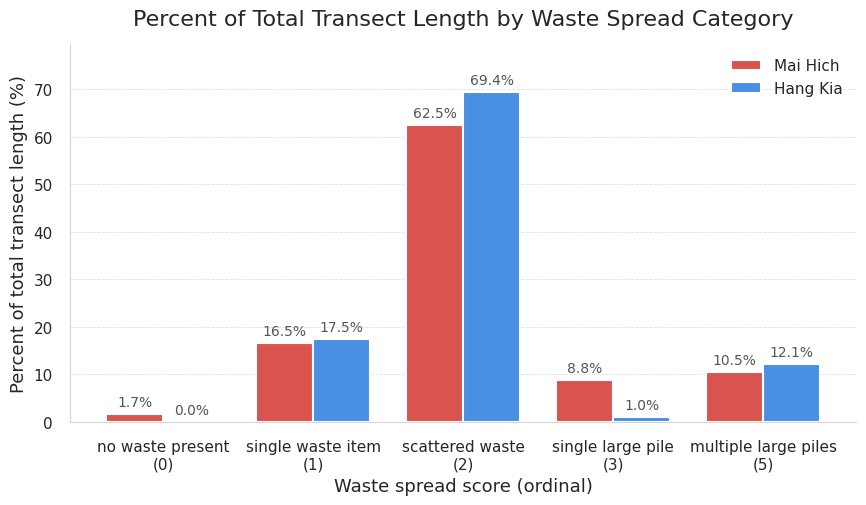

In [48]:
sns.set(style="whitegrid", context="talk")

# ---------------------------------------------------
# 1. PREP FROM EXISTING spread_summary
# ---------------------------------------------------
ordered_scores = sorted(spread_summary["spread_trs"].dropna().unique())

hk = spread_summary[spread_summary["commune"] == "Hang Kia"].set_index("spread_trs")
mh = spread_summary[spread_summary["commune"] == "Mai Hich"].set_index("spread_trs")

hk_percents = hk.reindex(ordered_scores)["Percent_of_Commune_Length"].fillna(0)
mh_percents = mh.reindex(ordered_scores)["Percent_of_Commune_Length"].fillna(0)

# ---------------------------------------------------
# 2. COLORS
# ---------------------------------------------------
mh_red  = "#D9534F"
hk_blue = "#4A90E2"

# ---------------------------------------------------
# 3. FIGURE
# ---------------------------------------------------
x = np.arange(len(ordered_scores))
width = 0.38

fig, ax = plt.subplots(figsize=(9, 5.4))

bars_mh = ax.bar(
    x - width/2,
    mh_percents,
    width=width,
    color=mh_red,
    label="Mai Hich",
    zorder=3
)

bars_hk = ax.bar(
    x + width/2,
    hk_percents,
    width=width,
    color=hk_blue,
    label="Hang Kia",
    zorder=3
)

# ---------------------------------------------------
# 4. TITLES + AXES (IMPROVED X LABELS)
# ---------------------------------------------------
label_map = {
    0: "no waste present\n(0)",
    1: "single waste item\n(1)",
    2: "scattered waste\n(2)",
    3: "single large pile\n(3)",
    5: "multiple large piles\n(5)",
}

ax.set_title(
    "Percent of Total Transect Length by Waste Spread Category",
    fontsize=16,
    pad=14
)

ax.set_xlabel("Waste spread score (ordinal)", fontsize=13)
ax.set_ylabel("Percent of total transect length (%)", fontsize=13)

ax.set_xticks(x)
ax.set_xticklabels(
    [label_map.get(s, str(s)) for s in ordered_scores],
    fontsize=11
)

ax.tick_params(axis="y", labelsize=11)

upper = max(np.nanmax(hk_percents), np.nanmax(mh_percents))
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 5. GRID + SPINES + LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 6. BAR ANNOTATIONS
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + upper * 0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555"
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 7. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


### Waste Types

In [21]:
waste_type_cols = [
    'organic_pr',
    'plastic_pr',
    'paper_pr',
    'hazard_pr',
    'glssmtl_pr']

tmp = full.copy()
tmp["length_m"] = pd.to_numeric(tmp["length_m"], errors="coerce")

# ------------------------
# A) Count of segments where type == 1
# ------------------------
type_counts = (
    tmp.groupby("commune")[waste_type_cols]
       .sum()
       .reset_index()
)

# ------------------------
# B) Total length where type == 1
# ------------------------
length_rows = []
for commune_name, dfc in tmp.groupby("commune"):
    for col in waste_type_cols:
        length_sum = dfc.loc[dfc[col] == 1, "length_m"].sum()
        length_rows.append([commune_name, col, round(length_sum, 2)])

type_lengths = pd.DataFrame(length_rows, columns=["commune", "Waste_Type", "Total_Length_m"])

# pivot length table to wide form per commune × type
type_lengths_wide = type_lengths.pivot(index="commune", columns="Waste_Type", values="Total_Length_m")

# ------------------------
# C) Percent of total length per commune
# ------------------------
total_length = tmp.groupby("commune")["length_m"].sum()

percent_rows = []
for commune_name, dfc in tmp.groupby("commune"):
    for col in waste_type_cols:
        length_sum = type_lengths_wide.loc[commune_name, col]
        pct = (length_sum / total_length.loc[commune_name] * 100) if total_length.loc[commune_name] > 0 else 0
        percent_rows.append([commune_name, col, round(pct, 1)])

type_percent = pd.DataFrame(percent_rows, columns=["commune", "Waste_Type", "Percent_of_Commune_Length"])

# ------------------------
# D) Final tidy table
# ------------------------
waste_type_table = (
    type_counts.melt(id_vars="commune", var_name="Waste_Type", value_name="Frequency")
    .merge(type_lengths, on=["commune", "Waste_Type"])
    .merge(type_percent, on=["commune", "Waste_Type"])
    .sort_values(["Waste_Type", "commune"])
    .reset_index(drop=True)
)

waste_type_table


,commune,Waste_Type,Frequency,Total_Length_m,Percent_of_Commune_Length
0,Hang Kia,glssmtl_pr,10,4669.84,25.9
1,Mai Hich,glssmtl_pr,26,13003.66,22.8
2,Hang Kia,hazard_pr,1,430.55,2.4
3,Mai Hich,hazard_pr,12,6402.44,11.2
4,Hang Kia,organic_pr,18,7152.06,39.7
5,Mai Hich,organic_pr,78,38190.17,66.9
6,Hang Kia,paper_pr,29,10527.55,58.4
7,Mai Hich,paper_pr,55,28239.59,49.5
8,Hang Kia,plastic_pr,51,18017.26,100.0
9,Mai Hich,plastic_pr,110,53919.47,94.5


In [22]:
# Make a copy so we don't overwrite the original
wt_pretty = waste_type_table.copy()

# 1. Nicer column labels
wt_pretty = wt_pretty.rename(columns={
    "commune": "Commune",
    "Waste_Type": "Waste type",
    "Frequency": "Frequency (segments)",
    "Total_Length_m": "Total length (m)",
    "Percent_of_Commune_Length": "% of commune length"
})

# 2. Optional: order columns
wt_pretty = wt_pretty[[
    "Commune",
    "Waste type",
    "Frequency (segments)",
    "Total length (m)",
    "% of commune length"
]]

# 3. Optional: sort logical order (by waste type, then commune)
wt_pretty = wt_pretty.sort_values(["Waste type", "Commune"]).reset_index(drop=True)

# 4. Styling: alternating gray rows, nice headers, rounded numbers
def stripe_rows(row):
    # even rows white, odd rows light gray
    return ['background-color: #f7f7f7' if row.name % 2 else '' for _ in row]

styled_wt = (
    wt_pretty.style
    .apply(stripe_rows, axis=1)                           # row striping
    .set_properties(**{"text-align": "center"})          # center text
    .set_table_styles(
        [
            {"selector": "th",
             "props": [("background-color", "#e0e0e0"),
                       ("font-weight", "bold"),
                       ("text-align", "center")]},
            {"selector": "tbody td",
             "props": [("border", "1px solid #d0d0d0")]},
            {"selector": "table",
             "props": [("border-collapse", "collapse"),
                       ("font-size", "11pt")]}
        ]
    )
    .format({
        "Total length (m)": "{:.1f}",
        "% of commune length": "{:.1f}"
    })
    .hide(axis="index")  # hide row index
)

styled_wt


Commune,Waste type,Frequency (segments),Total length (m),% of commune length
Hang Kia,glssmtl_pr,10,4669.8,25.9
Mai Hich,glssmtl_pr,26,13003.7,22.8
Hang Kia,hazard_pr,1,430.6,2.4
Mai Hich,hazard_pr,12,6402.4,11.2
Hang Kia,organic_pr,18,7152.1,39.7
Mai Hich,organic_pr,78,38190.2,66.9
Hang Kia,paper_pr,29,10527.5,58.4
Mai Hich,paper_pr,55,28239.6,49.5
Hang Kia,plastic_pr,51,18017.3,100.0
Mai Hich,plastic_pr,110,53919.5,94.5


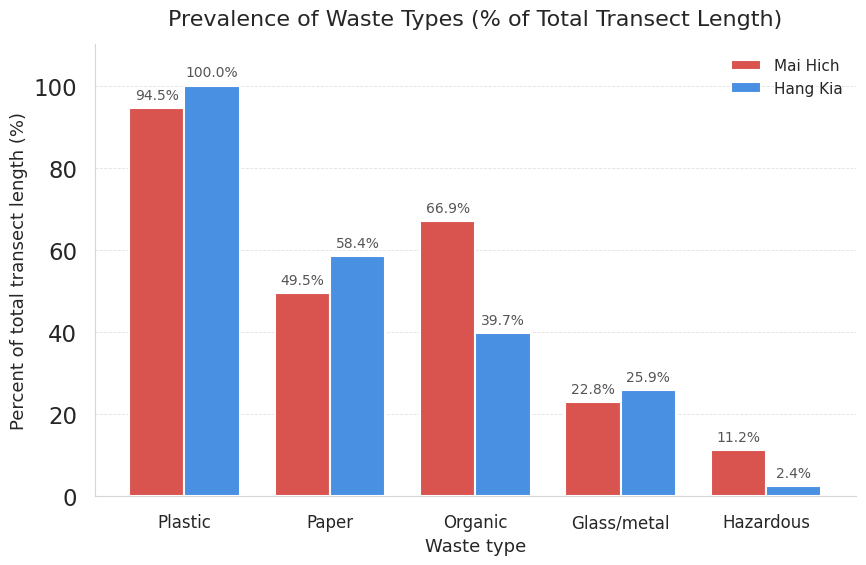

In [23]:
sns.set(style="whitegrid", context="talk")

mh_red  = "#D9534F"
hk_blue = "#4A90E2"

# ---------------------------------------------------
# 1. ORDER + LABELS
# ---------------------------------------------------
waste_type_order = ['plastic_pr', 'paper_pr', 'organic_pr', 'glssmtl_pr', 'hazard_pr']

label_map = {
    'plastic_pr': 'Plastic',
    'paper_pr': 'Paper',
    'organic_pr': 'Organic',
    'glssmtl_pr': 'Glass/metal',
    'hazard_pr': 'Hazardous'
}

hk = (waste_type_table[waste_type_table["commune"] == "Hang Kia"]
      .set_index("Waste_Type")
      .reindex(waste_type_order))

mh = (waste_type_table[waste_type_table["commune"] == "Mai Hich"]
      .set_index("Waste_Type")
      .reindex(waste_type_order))

hk_perc = hk["Percent_of_Commune_Length"].fillna(0)
mh_perc = mh["Percent_of_Commune_Length"].fillna(0)

x = np.arange(len(waste_type_order))
width = 0.38

# ---------------------------------------------------
# 2. FIGURE
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))

bars_mh = ax.bar(
    x - width/2,
    mh_perc,
    width=width,
    color=mh_red,
    label="Mai Hich",
    zorder=3
)

bars_hk = ax.bar(
    x + width/2,
    hk_perc,
    width=width,
    color=hk_blue,
    label="Hang Kia",
    zorder=3
)

# ---------------------------------------------------
# 3. AXES / LABELS / TITLE
# ---------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels([label_map[w] for w in waste_type_order], fontsize=12)

ax.set_xlabel("Waste type", fontsize=13)
ax.set_ylabel("Percent of total transect length (%)", fontsize=13)
ax.set_title("Prevalence of Waste Types (% of Total Transect Length)", fontsize=16, pad=14)

upper = max(hk_perc.max(), mh_perc.max())
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 4. GRID + SPINES + LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 5. ANNOTATIONS — clean, small, grey
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + upper*0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555"
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 6. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


### Waste Diversity


In [24]:
# ---------- helper function so HK & MH use identical logic ----------
def make_diversity_table(df_sub):
    # A) Unique diversity scores present
    diversity_scores = sorted(df_sub['waste_diversity'].unique())

    # B) Frequency: number of segments per diversity score
    div_count = (
        df_sub['waste_diversity']
        .value_counts()
        .reindex(diversity_scores, fill_value=0)
    )

    # C) Total length (m) per diversity score
    div_length_m = {
        d: df_sub.loc[df_sub['waste_diversity'] == d, 'length_m'].sum()
        for d in diversity_scores
    }
    div_length_m = pd.Series(div_length_m).round(2)

    # D) Percent of total length (within that commune)
    total_length = df_sub['length_m'].sum()
    div_percent_length = ((div_length_m / total_length) * 100).round(1)

    # E) Final table (same structure as your original)
    table = pd.DataFrame({
        'Waste_Diversity': diversity_scores,
        'Frequency': div_count.values,
        'Total_Length_m': div_length_m.values,
        'Percent_of_Total_Length': div_percent_length.values
    })
    return table

# ---------- apply to FULL dataframe ----------
hk = full[full['commune'] == 'Hang Kia'].copy()
mh = full[full['commune'] == 'Mai Hich'].copy()

hk_waste_diversity_table = make_diversity_table(hk)
mh_waste_diversity_table = make_diversity_table(mh)

hk_waste_diversity_table


,Waste_Diversity,Frequency,Total_Length_m,Percent_of_Total_Length
0,1,20,7079.71,39.3
1,2,11,2606.23,14.5
2,3,14,5250.73,29.1
3,4,5,2650.04,14.7
4,5,1,430.55,2.4


In [25]:
mh_waste_diversity_table


,Waste_Diversity,Frequency,Total_Length_m,Percent_of_Total_Length
0,1,30,14250.33,25.0
1,2,35,16267.65,28.5
2,3,32,15898.52,27.9
3,4,15,7963.53,14.0
4,5,5,2684.00,4.7


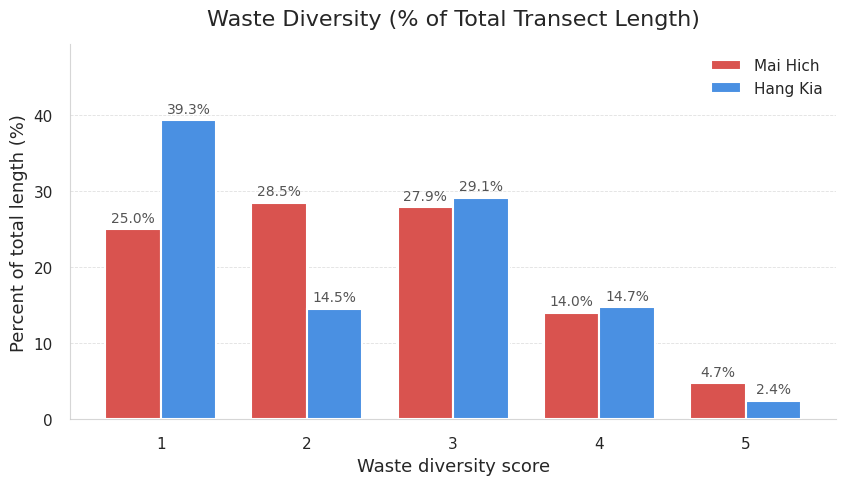

In [26]:
sns.set(style="whitegrid", context="talk")

mh_red  = "#D9534F"
hk_blue = "#4A90E2"

# ---------------------------------------------------
# 1. SORT TABLES BY WASTE_DIVERSITY
# ---------------------------------------------------
hk_sorted = hk_waste_diversity_table.sort_values("Waste_Diversity").reset_index(drop=True)
mh_sorted = mh_waste_diversity_table.sort_values("Waste_Diversity").reset_index(drop=True)

div_scores = hk_sorted["Waste_Diversity"].tolist()
x = np.arange(len(div_scores))
width = 0.38

hk_perc = hk_sorted["Percent_of_Total_Length"].values
mh_perc = mh_sorted["Percent_of_Total_Length"].values

# ---------------------------------------------------
# 2. FIGURE – SIDE-BY-SIDE BARS
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(8.8, 5.2))

bars_mh = ax.bar(
    x - width/2,
    mh_perc,
    width=width,
    color=mh_red,
    label="Mai Hich",
    zorder=3
)

bars_hk = ax.bar(
    x + width/2,
    hk_perc,
    width=width,
    color=hk_blue,
    label="Hang Kia",
    zorder=3
)

# ---------------------------------------------------
# 3. AXIS LABELS / TITLE
# ---------------------------------------------------
ax.set_title("Waste Diversity (% of Total Transect Length)", fontsize=16, pad=14)
ax.set_xlabel("Waste diversity score", fontsize=13)
ax.set_ylabel("Percent of total length (%)", fontsize=13)

ax.set_xticks(x)
ax.set_xticklabels([str(s) for s in div_scores], fontsize=11)
ax.tick_params(axis="y", labelsize=11)

upper = max(np.nanmax(hk_perc), np.nanmax(mh_perc))
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 4. GRID, SPINES, LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 5. ANNOTATIONS – SMALL + GREY
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        if np.isnan(h):
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + upper * 0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555"
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 6. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


### Informal Disposal Behaviour

#### Burning

In [27]:
# ---------------------------------------------------------
# Burning evidence per commune
# ---------------------------------------------------------

# (Optional but safe) clean commune labels
full['commune'] = full['commune'].astype(str).str.strip()

# 1. Aggregate by commune × burning
tbl = (
    full.groupby(['commune', 'burning'])['length_m']
      .agg(Count='count', Total_Length_m='sum')
)

# 2. Total walked length per commune (fresh from full)
commune_totals = full.groupby('commune')['length_m'].sum()

# 3. Percent of each commune's total length
tbl['Percent_of_Commune_Length'] = (
    tbl['Total_Length_m'] /
    tbl.index.get_level_values('commune').map(commune_totals) * 100
).round(1)

# 4. Nice rounding + reset index
tbl['Total_Length_m'] = tbl['Total_Length_m'].round(2)

burning_commune_table = tbl.reset_index()
burning_commune_table

,commune,burning,Count,Total_Length_m,Percent_of_Commune_Length
0,Hang Kia,0,25,8875.24,49.3
1,Hang Kia,1,26,9142.02,50.7
2,Mai Hich,0,82,38913.60,68.2
3,Mai Hich,1,35,18150.44,31.8


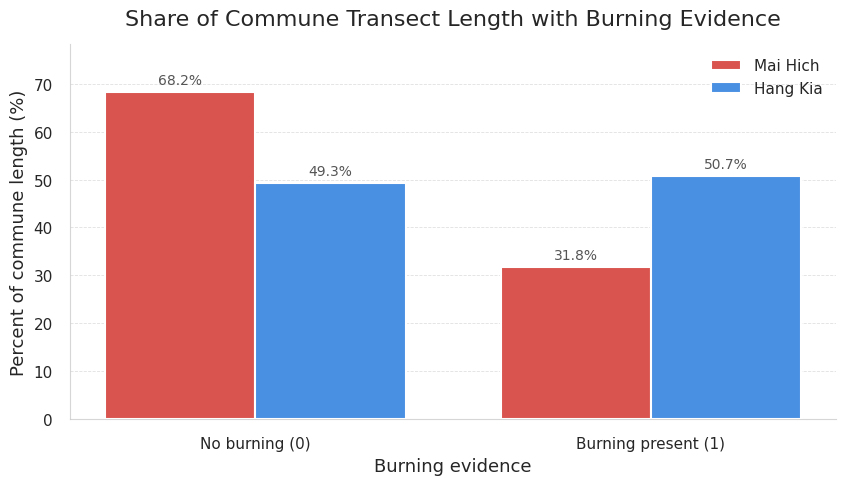

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid", context="talk")

mh_red  = "#D9534F"   # Mai Hich
hk_blue = "#4A90E2"   # Hang Kia

# ---------------------------------------------------
# 1. PREP DATA FROM burning_commune_table
# ---------------------------------------------------
plot_df = burning_commune_table.copy()

# Ensure expected communes & burning order
plot_df = plot_df.sort_values(["burning", "commune"])

# Map 0/1 to readable labels
burn_label_map = {
    0: "No burning (0)",
    1: "Burning present (1)"
}
plot_df["burn_label"] = plot_df["burning"].map(burn_label_map)

# Separate HK and MH in correct burning order
hk = plot_df[plot_df["commune"] == "Hang Kia"].sort_values("burning")
mh = plot_df[plot_df["commune"] == "Mai Hich"].sort_values("burning")

burn_labels = hk["burn_label"].tolist()  # ['No burning (0)', 'Burning present (1)']
x = np.arange(len(burn_labels))
width = 0.38

hk_perc = hk["Percent_of_Commune_Length"].values
mh_perc = mh["Percent_of_Commune_Length"].values

# ---------------------------------------------------
# 2. FIGURE – SIDE-BY-SIDE BARS
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(8.8, 5.2))

bars_mh = ax.bar(
    x - width/2,
    mh_perc,
    width=width,
    color=mh_red,
    label="Mai Hich",
    zorder=3
)

bars_hk = ax.bar(
    x + width/2,
    hk_perc,
    width=width,
    color=hk_blue,
    label="Hang Kia",
    zorder=3
)

# ---------------------------------------------------
# 3. AXIS LABELS / TITLE
# ---------------------------------------------------
ax.set_title(
    "Share of Commune Transect Length with Burning Evidence",
    fontsize=16,
    pad=14
)
ax.set_xlabel("Burning evidence", fontsize=13)
ax.set_ylabel("Percent of commune length (%)", fontsize=13)

ax.set_xticks(x)
ax.set_xticklabels(burn_labels, fontsize=11)
ax.tick_params(axis="y", labelsize=11)

upper = max(np.nanmax(hk_perc), np.nanmax(mh_perc))
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 4. GRID, SPINES, LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 5. ANNOTATIONS – SMALL + GREY
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        if np.isnan(h):
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + upper * 0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555"
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 6. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


#### Open Dumping

In [29]:
# Dumping evidence per commune (using full)

full['commune'] = full['commune'].astype(str).str.strip()

tbl = (
    full.groupby(['commune', 'opendumping_present'])['length_m']
        .agg(Count='count', Total_Length_m='sum'))

# Total length per commune
commune_totals = full.groupby('commune')['length_m'].sum()

# Percent of each commune's transect length
tbl['Percent_of_Commune_Length'] = (
    tbl['Total_Length_m'] /
    tbl.index.get_level_values('commune').map(commune_totals) * 100
).round(1)

tbl['Total_Length_m'] = tbl['Total_Length_m'].round(2)

dumping_commune_table = tbl.reset_index()
dumping_commune_table


,commune,opendumping_present,Count,Total_Length_m,Percent_of_Commune_Length
0,Hang Kia,0,28,10946.50,60.8
1,Hang Kia,1,23,7070.76,39.2
2,Mai Hich,0,75,34513.28,60.5
3,Mai Hich,1,42,22550.76,39.5


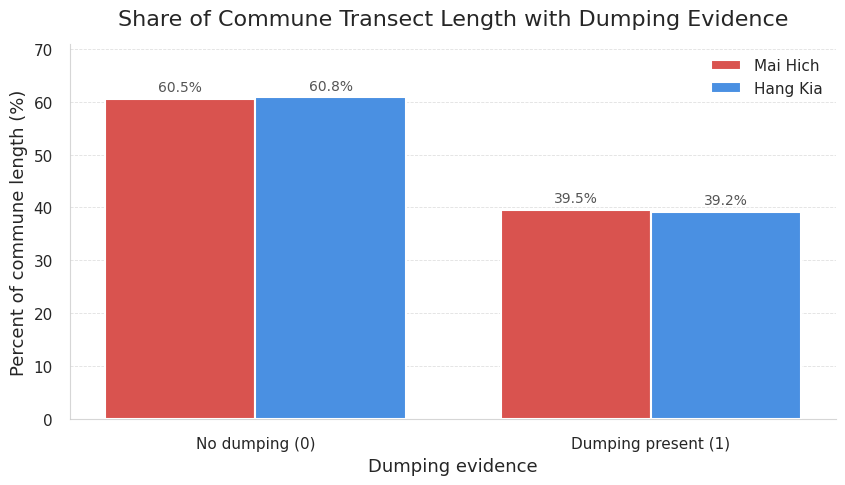

In [30]:
sns.set(style="whitegrid", context="talk")

mh_red  = "#D9534F"   # Mai Hich
hk_blue = "#4A90E2"   # Hang Kia

# ---------------------------------------------------
# 1. PREP DATA FROM dumping_commune_table
# ---------------------------------------------------
plot_df = dumping_commune_table.copy()

# Ensure proper sorting: first by dumping (0 → 1), then commune
plot_df = plot_df.sort_values(["opendumping_present", "commune"])

# Map 0/1 to readable labels
dump_label_map = {
    0: "No dumping (0)",
    1: "Dumping present (1)"
}
plot_df["dump_label"] = plot_df["opendumping_present"].map(dump_label_map)

# Separate HK and MH in correct order
hk = plot_df[plot_df["commune"] == "Hang Kia"].sort_values("opendumping_present")
mh = plot_df[plot_df["commune"] == "Mai Hich"].sort_values("opendumping_present")

dump_labels = hk["dump_label"].tolist()
x = np.arange(len(dump_labels))
width = 0.38

hk_perc = hk["Percent_of_Commune_Length"].values
mh_perc = mh["Percent_of_Commune_Length"].values

# ---------------------------------------------------
# 2. FIGURE – SIDE-BY-SIDE BARS
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(8.8, 5.2))

bars_mh = ax.bar(
    x - width/2,
    mh_perc,
    width=width,
    color=mh_red,
    label="Mai Hich",
    zorder=3
)

bars_hk = ax.bar(
    x + width/2,
    hk_perc,
    width=width,
    color=hk_blue,
    label="Hang Kia",
    zorder=3
)

# ---------------------------------------------------
# 3. TITLE + LABELS
# ---------------------------------------------------
ax.set_title(
    "Share of Commune Transect Length with Dumping Evidence",
    fontsize=16,
    pad=14
)
ax.set_xlabel("Dumping evidence", fontsize=13)
ax.set_ylabel("Percent of commune length (%)", fontsize=13)

ax.set_xticks(x)
ax.set_xticklabels(dump_labels, fontsize=11)
ax.tick_params(axis="y", labelsize=11)

upper = max(np.nanmax(hk_perc), np.nanmax(mh_perc))
ax.set_ylim(0, upper + 10)

# ---------------------------------------------------
# 4. GRID, SPINES, LEGEND
# ---------------------------------------------------
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)
ax.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

for spine in ["left", "bottom"]:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_alpha(0.8)

ax.legend(frameon=False, fontsize=11, loc="upper right")

# ---------------------------------------------------
# 5. ANNOTATIONS – SMALL, GREY, CLEAN
# ---------------------------------------------------
def annotate(bars):
    for bar in bars:
        h = bar.get_height()
        if np.isnan(h):
            continue
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + upper * 0.015,
            f"{h:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            color="#555555"
        )

annotate(bars_mh)
annotate(bars_hk)

# ---------------------------------------------------
# 6. LAYOUT
# ---------------------------------------------------
fig.tight_layout()
# plt.show()


# 🪜 1.3 Non-parametric Correlation Analysis

### Spearman (Ordinal/Continous)

In [31]:
# Hang Kia only from `full`

hk = full.copy()
hk['commune'] = hk['commune'].astype(str).str.strip()
hk = hk[hk['commune'] == "Hang Kia"]

# ---------------------------------------------------------
# 1. Human-readable variable labels
# ---------------------------------------------------------
label_map = {
    "trash_bins_per_200m": "Bin density (per 200m)",
    "vol_waste": "Waste severity",
    "burning_per_200m": "Burning intensity (per 200m)",
    "building_density_per_200m": "Building density (per 200m)",
    "opendumping_per_200m": "Open dumping intensity (per 200m)",
    "waste_diversity": "Waste-type diversity",
    "spread_trs": "Waste spread"
}

# ------------------------
# 2. Predictor–Outcome pairs
# ------------------------
tests = [
    ("trash_bins_per_200m", "vol_waste"),
    ("burning_per_200m", "vol_waste"),
    ("building_density_per_200m", "vol_waste"),
    ("building_density_per_200m", "opendumping_per_200m"),
    ("building_density_per_200m", "burning_per_200m"),
    ("building_density_per_200m", "waste_diversity"),
    ("building_density_per_200m", "spread_trs")
]

# ---------------------------------------------------------
# 3. Build Result Table (HANG KIA ONLY)
# ---------------------------------------------------------
rows = []

for x, y in tests:
    rho, p = spearmanr(hk[x], hk[y], nan_policy='omit')

    readable_x = label_map[x].lower()
    readable_y = label_map[y].lower()

    if p < 0.05:
        if rho > 0:
            interp = (
                f"There is a significant positive association: "
                f"higher {readable_x} is linked with higher {readable_y}."
            )
        elif rho < 0:
            interp = (
                f"There is a significant negative association: "
                f"higher {readable_x} is linked with lower {readable_y}."
            )
        else:
            interp = (
                f"Although statistically significant, the direction of the "
                f"relationship between {readable_x} and {readable_y} is unclear."
            )
    else:
        interp = (
            f"There is no statistically meaningful relationship between "
            f"{readable_x} and {readable_y} (p ≥ 0.05)."
        )

    rows.append([label_map[x], label_map[y], rho, p, interp])

# ---------------------------------------------------------
# 4. DataFrame
# ---------------------------------------------------------
results_df = pd.DataFrame(
    rows,
    columns=["Predictor", "Outcome", "Spearman rho", "p-value", "Interpretation"]
)

# ---------------------------------------------------------
# 5. Highlight significant p-values (green) + fixed rounding
# ---------------------------------------------------------
def highlight_sig(value):
    return "background-color: #c4f7c4" if value < 0.05 else ""

def smart_format(x):
    if abs(x) < 0.001 and x != 0:
        return f"{x:.2e}"
    else:
        return f"{x:.3f}"

hk_styled_results = (
    results_df
    .style
    .applymap(highlight_sig, subset=["p-value"])
    .format({
        "Spearman rho": smart_format,
        "p-value": smart_format
    })
)

hk_styled_results


/tmp/ipython-input-3295716422.py:91: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_sig, subset=["p-value"])


,Predictor,Outcome,Spearman rho,p-value,Interpretation
0,Bin density (per 200m),Waste severity,0.242,0.087,There is no statistically meaningful relationship between bin density (per 200m) and waste severity (p ≥ 0.05).
1,Burning intensity (per 200m),Waste severity,0.315,0.024,There is a significant positive association: higher burning intensity (per 200m) is linked with higher waste severity.
2,Building density (per 200m),Waste severity,0.151,0.290,There is no statistically meaningful relationship between building density (per 200m) and waste severity (p ≥ 0.05).
3,Building density (per 200m),Open dumping intensity (per 200m),0.098,0.493,There is no statistically meaningful relationship between building density (per 200m) and open dumping intensity (per 200m) (p ≥ 0.05).
4,Building density (per 200m),Burning intensity (per 200m),0.503,1.69e-04,There is a significant positive association: higher building density (per 200m) is linked with higher burning intensity (per 200m).
5,Building density (per 200m),Waste-type diversity,0.530,6.34e-05,There is a significant positive association: higher building density (per 200m) is linked with higher waste-type diversity.
6,Building density (per 200m),Waste spread,0.296,0.035,There is a significant positive association: higher building density (per 200m) is linked with higher waste spread.


In [32]:
#Mai Hich only from `full`

mh = full.copy()
mh['commune'] = mh['commune'].astype(str).str.strip()
mh = mh[mh['commune'] == "Mai Hich"]

# ---------------------------------------------------------
# 1. Human-readable variable labels
# ---------------------------------------------------------
label_map = {
    "trash_bins_per_200m": "Bin density (per 200m)",
    "vol_waste": "Waste severity",
    "burning_per_200m": "Burning intensity (per 200m)",
    "building_density_per_200m": "Building density (per 200m)",
    "opendumping_per_200m": "Open dumping intensity (per 200m)",
    "waste_diversity": "Waste-type diversity",
    "spread_trs": "Waste spread"
}

# ------------------------
# 2. Predictor–Outcome pairs
# ------------------------
tests = [
    ("trash_bins_per_200m", "vol_waste"),
    ("burning_per_200m", "vol_waste"),
    ("building_density_per_200m", "vol_waste"),
    ("building_density_per_200m", "opendumping_per_200m"),
    ("building_density_per_200m", "burning_per_200m"),
    ("building_density_per_200m", "waste_diversity"),
    ("building_density_per_200m", "spread_trs")
]

# ---------------------------------------------------------
# 3. Build Result Table (MAI HICH ONLY)
# ---------------------------------------------------------
rows = []

for x, y in tests:
    rho, p = spearmanr(mh[x], mh[y], nan_policy='omit')

    readable_x = label_map[x].lower()
    readable_y = label_map[y].lower()

    if p < 0.05:
        if rho > 0:
            interp = (
                f"There is a significant positive association: "
                f"higher {readable_x} is linked with higher {readable_y}."
            )
        elif rho < 0:
            interp = (
                f"There is a significant negative association: "
                f"higher {readable_x} is linked with lower {readable_y}."
            )
        else:
            interp = (
                f"Although statistically significant, the direction of the "
                f"relationship between {readable_x} and {readable_y} is unclear."
            )
    else:
        interp = (
            f"There is no statistically meaningful relationship between "
            f"{readable_x} and {readable_y} (p ≥ 0.05)."
        )

    rows.append([label_map[x], label_map[y], rho, p, interp])

# ---------------------------------------------------------
# 4. DataFrame
# ---------------------------------------------------------
results_df_mh = pd.DataFrame(
    rows,
    columns=["Predictor", "Outcome", "Spearman rho", "p-value", "Interpretation"]
)

# ---------------------------------------------------------
# 5. Highlight significant p-values (green) + fixed rounding
# ---------------------------------------------------------
def highlight_sig(value):
    return "background-color: #c4f7c4" if value < 0.05 else ""

def smart_format(x):
    if abs(x) < 0.001 and x != 0:
        return f"{x:.2e}"
    else:
        return f"{x:.3f}"

styled_results_mh = (
    results_df_mh
    .style
    .applymap(highlight_sig, subset=["p-value"])
    .format({
        "Spearman rho": smart_format,
        "p-value": smart_format
    })
)

styled_results_mh


/tmp/ipython-input-401579175.py:91: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_sig, subset=["p-value"])


,Predictor,Outcome,Spearman rho,p-value,Interpretation
0,Bin density (per 200m),Waste severity,-0.051,0.587,There is no statistically meaningful relationship between bin density (per 200m) and waste severity (p ≥ 0.05).
1,Burning intensity (per 200m),Waste severity,0.199,0.031,There is a significant positive association: higher burning intensity (per 200m) is linked with higher waste severity.
2,Building density (per 200m),Waste severity,0.046,0.625,There is no statistically meaningful relationship between building density (per 200m) and waste severity (p ≥ 0.05).
3,Building density (per 200m),Open dumping intensity (per 200m),0.006,0.945,There is no statistically meaningful relationship between building density (per 200m) and open dumping intensity (per 200m) (p ≥ 0.05).
4,Building density (per 200m),Burning intensity (per 200m),-0.036,0.699,There is no statistically meaningful relationship between building density (per 200m) and burning intensity (per 200m) (p ≥ 0.05).
5,Building density (per 200m),Waste-type diversity,-0.102,0.273,There is no statistically meaningful relationship between building density (per 200m) and waste-type diversity (p ≥ 0.05).
6,Building density (per 200m),Waste spread,-0.026,0.810,There is no statistically meaningful relationship between building density (per 200m) and waste spread (p ≥ 0.05).


### Mann-Whitney U (Ordinal/Binary)

#### Burning and Vol Waste

In [33]:
# Crosstab_HK: percent of each category by burning group
ordinal_vals = [0, 1, 3, 5]

hk_vol_crosstab = (
    pd.crosstab(df['burning'], df['vol_waste'], normalize='index') * 100
).reindex(columns=ordinal_vals).fillna(0)

hk_vol_crosstab


vol_waste,0,1,3,5
burning,,,,
0,16.0,68.000000,12.000000,4.000000
1,0.0,57.692308,38.461538,3.846154


/tmp/ipython-input-1201308751.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


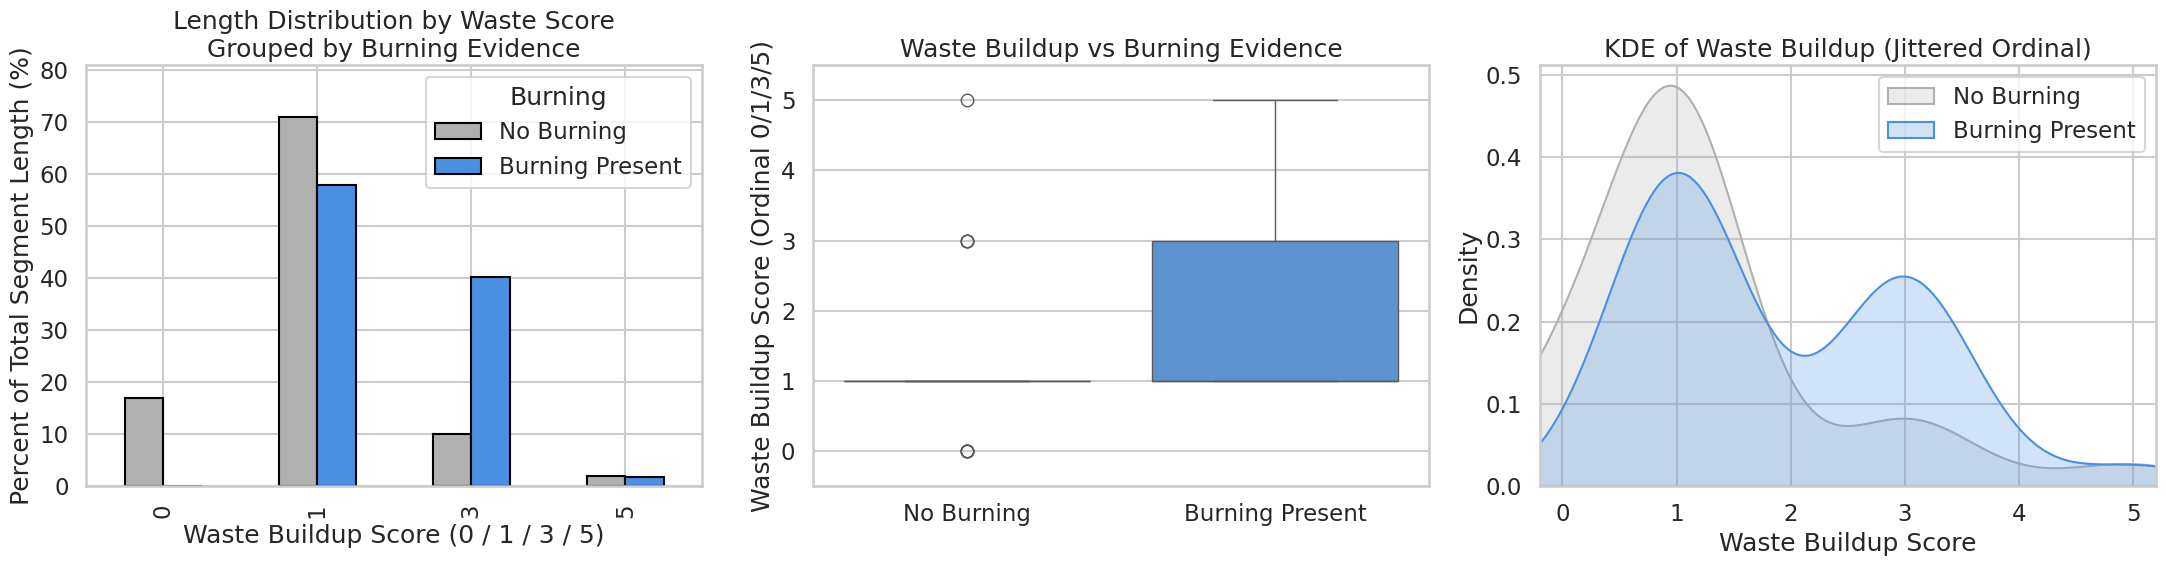

In [34]:
sns.set(style="whitegrid", context="talk")

# Order of ordinal scores
ordinal_vals = [0, 1, 3, 5]

# ---------------------------------------------------
# 1. COMPUTE % OF TOTAL LENGTH PER WASTE CATEGORY
# ---------------------------------------------------
vol_length = (
    df.groupby(['burning', 'vol_waste'])['length_m']
      .sum()
      .unstack(fill_value=0)
      .reindex(columns=ordinal_vals)
)

vol_percent_length = (
    vol_length.div(vol_length.sum(axis=1), axis=0) * 100
).round(1)

# ---------------------------------------------------
# 2. CREATE FIGURE WITH 3 PANELS
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ================================
# PANEL 1 — Bar Chart by Burning
# ================================
vol_percent_length.T.plot(
    kind='bar',
    ax=axes[0],
    color=['#b0b0b0', '#4A90E2'],
    edgecolor='black'
)

axes[0].set_title("Length Distribution by Waste Score\nGrouped by Burning Evidence")
axes[0].set_xlabel("Waste Buildup Score (0 / 1 / 3 / 5)")
axes[0].set_ylabel("Percent of Total Segment Length (%)")
axes[0].legend(["No Burning", "Burning Present"], title="Burning")
axes[0].set_ylim(0, vol_percent_length.max().max() + 10)

# ================================
# PANEL 2 — Boxplot
# ================================
sns.boxplot(
    data=df,
    x=df['burning'].map({0: "No Burning", 1: "Burning Present"}),
    y='vol_waste',
    ax=axes[1],
    palette=["#b0b0b0", "#4A90E2"]
)

axes[1].set_title("Waste Buildup vs Burning Evidence")
axes[1].set_xlabel("")
axes[1].set_ylabel("Waste Buildup Score (Ordinal 0/1/3/5)")
axes[1].set_ylim(-0.5, 5.5)

# ================================
# PANEL 3 — KDE (with jitter)
# ================================
df['vol_waste_jitter'] = df['vol_waste'] + np.random.uniform(-0.05, 0.05, size=len(df))

sns.kdeplot(
    data=df[df['burning'] == 0],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#b0b0b0',
    label="No Burning"
)

sns.kdeplot(
    data=df[df['burning'] == 1],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#4A90E2',
    label="Burning Present"
)

axes[2].set_title("KDE of Waste Buildup (Jittered Ordinal)")
axes[2].set_xlabel("Waste Buildup Score")
axes[2].set_xlim(-0.2, 5.2)
axes[2].legend()

plt.tight_layout()
plt.show()


In [35]:
#Mann Whitney U test for Hang Kia

burn0 = df[df['burning']==0]['vol_waste']
burn1 = df[df['burning']==1]['vol_waste']

stat, p = mannwhitneyu(burn0, burn1, alternative='two-sided')

print("Mann–Whitney U:", stat)
print("p-value:", p)


#   STATISTICAL INTERPRETATION:p = 0.0143 → below .05
#   Segments where burning occurs have higher waste volume severity
#   than those without burning.

Mann–Whitney U: 213.0
p-value: 0.014340138617730895


In [36]:
# Crosstab_MH: percent of each category by burning group
ordinal_vals = [0, 1, 3, 5]

mh_vol_crosstab = (
    pd.crosstab(df2['burning'], df2['vol_waste'], normalize='index') * 100
).reindex(columns=ordinal_vals).fillna(0)

mh_vol_crosstab


vol_waste,0,1,3,5
burning,,,,
0,14.634146,69.512195,13.414634,2.439024
1,2.857143,65.714286,28.571429,2.857143


/tmp/ipython-input-993789531.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


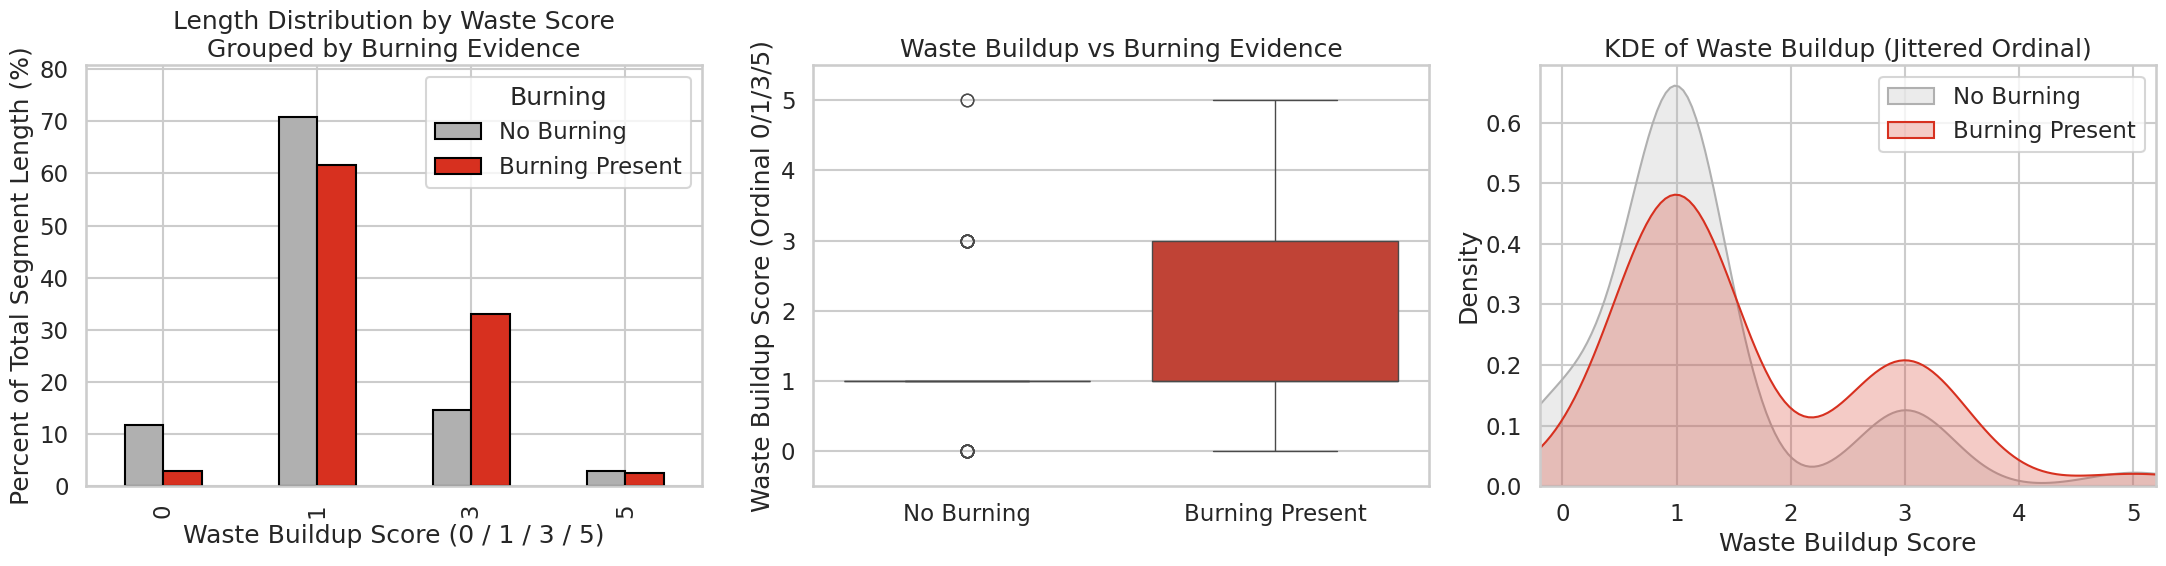

In [37]:
sns.set(style="whitegrid", context="talk")

# Order of ordinal scores
ordinal_vals = [0, 1, 3, 5]

# ---------------------------------------------------
# 1. COMPUTE % OF TOTAL LENGTH PER WASTE CATEGORY
# ---------------------------------------------------
mh_vol_length = (
    df2.groupby(['burning', 'vol_waste'])['length_m']
      .sum()
      .unstack(fill_value=0)
      .reindex(columns=ordinal_vals)
)

mh_vol_percent_length = (
    mh_vol_length.div(mh_vol_length.sum(axis=1), axis=0) * 100
).round(1)

# ---------------------------------------------------
# 2. CREATE FIGURE WITH 3 PANELS
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ================================
# PANEL 1 — Bar Chart by Burning
# ================================
mh_vol_percent_length.T.plot(
    kind='bar',
    ax=axes[0],
    color=['#b0b0b0', '#d7301f'],
    edgecolor='black'
)

axes[0].set_title("Length Distribution by Waste Score\nGrouped by Burning Evidence")
axes[0].set_xlabel("Waste Buildup Score (0 / 1 / 3 / 5)")
axes[0].set_ylabel("Percent of Total Segment Length (%)")
axes[0].legend(["No Burning", "Burning Present"], title="Burning")
axes[0].set_ylim(0, mh_vol_percent_length.max().max() + 10)

# ================================
# PANEL 2 — Boxplot
# ================================
sns.boxplot(
    data=df2,
    x=df2['burning'].map({0: "No Burning", 1: "Burning Present"}),
    y='vol_waste',
    ax=axes[1],
    palette=["#b0b0b0", "#d7301f"]
)

axes[1].set_title("Waste Buildup vs Burning Evidence")
axes[1].set_xlabel("")
axes[1].set_ylabel("Waste Buildup Score (Ordinal 0/1/3/5)")
axes[1].set_ylim(-0.5, 5.5)

# ================================
# PANEL 3 — KDE (with jitter)
# ================================
df2['vol_waste_jitter'] = df2['vol_waste'] + np.random.uniform(-0.05, 0.05, size=len(df2))

sns.kdeplot(
    data=df2[df2['burning'] == 0],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#b0b0b0',
    label="No Burning"
)

sns.kdeplot(
    data=df2[df2['burning'] == 1],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#d7301f',
    label="Burning Present"
)

axes[2].set_title("KDE of Waste Buildup (Jittered Ordinal)")
axes[2].set_xlabel("Waste Buildup Score")
axes[2].set_xlim(-0.2, 5.2)
axes[2].legend()

plt.tight_layout()
plt.show()


In [38]:
mh_burn0 = df2[df2['burning']==0]['vol_waste']
mh_burn1 = df2[df2['burning']==1]['vol_waste']

stat, p = mannwhitneyu(mh_burn0, mh_burn1, alternative='two-sided')

print("Mann–Whitney U:", stat)
print("p-value:", p)


#   STATISTICAL INTERPRETATION:p = 0.0173 → below .05
#   Segments where burning occurs have higher waste volume severity
#   than those without burning.

Mann–Whitney U: 1106.5
p-value: 0.017329811111043786


#### Bin Present and Vol Waste

In [39]:
# HK Crosstab: percent of each category by bins group
ordinal_vals = [0, 1, 3, 5]

# Create binary: 0 = no bins, 1 = bins present
df['bins_present'] = (df['trash_bins_per_200m'] > 0).astype(int)

vol_crosstab_bins = (
    pd.crosstab(df['bins_present'], df['vol_waste'], normalize='index') * 100
).reindex(columns=ordinal_vals).fillna(0)

vol_crosstab_bins


vol_waste,0,1,3,5
bins_present,,,,
0,11.428571,65.714286,20.0,2.857143
1,0.000000,56.250000,37.5,6.250000


/tmp/ipython-input-345673458.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


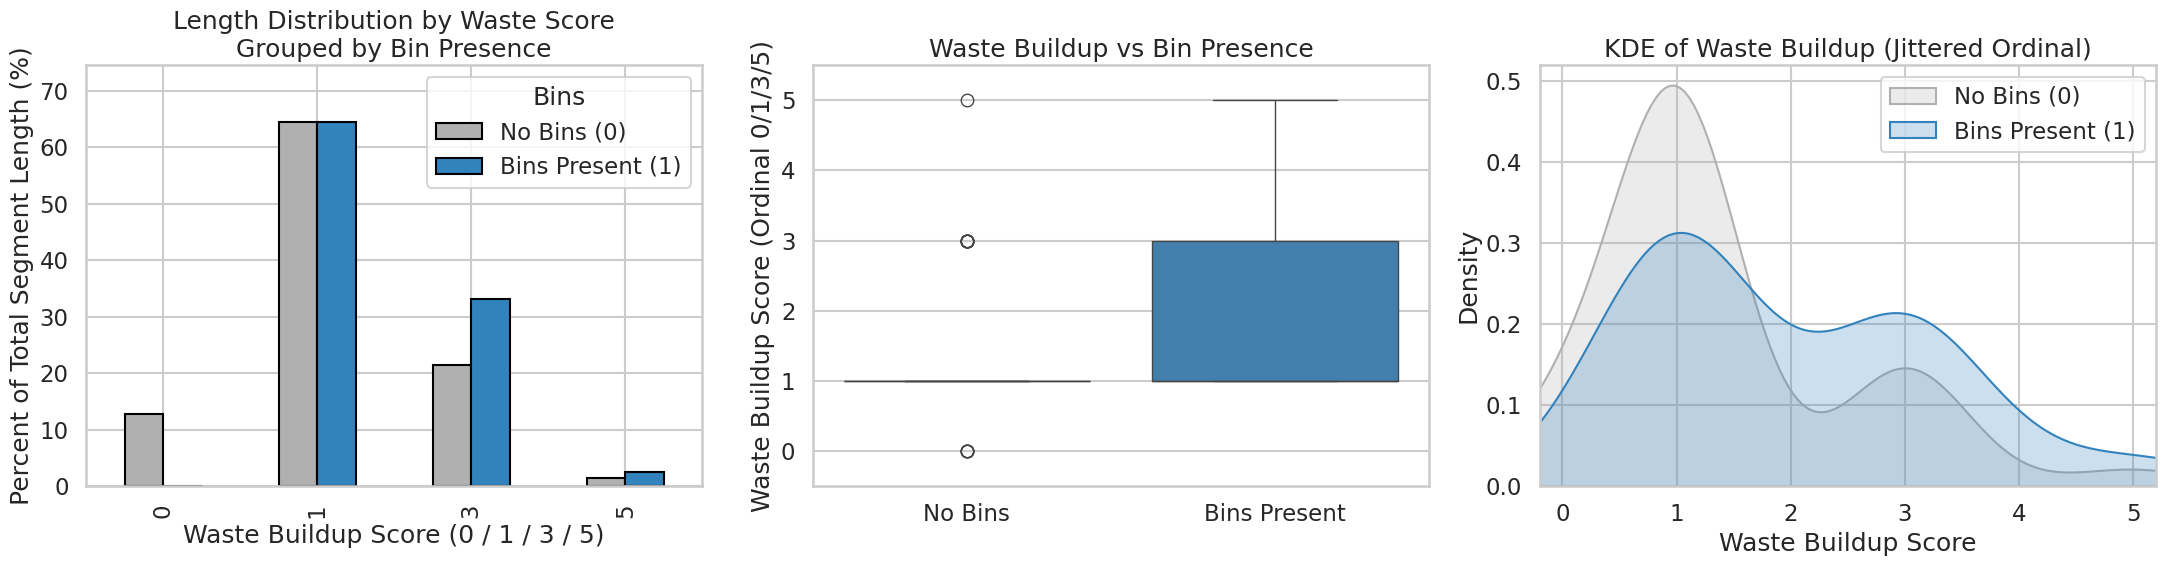

In [40]:
#FOR HANG KIA

sns.set(style="whitegrid", context="talk")

# -----------------------------
# 1. PREPARE ORDERED CATEGORIES
# -----------------------------
ordinal_vals = [0, 1, 3, 5]

# ensure binary column exists
df['bins_present'] = (df['trash_bins_per_200m'] > 0).astype(int)

# -----------------------------
# 2. COMPUTE % OF TOTAL LENGTH
# -----------------------------

vol_length_bins = (
    df.groupby(['bins_present', 'vol_waste'])['length_m']
      .sum()
      .unstack(fill_value=0)
      .reindex(columns=ordinal_vals)
)

vol_percent_length_bins = (
    vol_length_bins.div(vol_length_bins.sum(axis=1), axis=0) * 100
).round(1)

# -----------------------------
# 3. CREATE FIGURE (3 PANELS)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ============================================================
# PANEL 1 — Bar Chart (Percent Length)
# ============================================================

vol_percent_length_bins.T.plot(
    kind='bar',
    ax=axes[0],
    color=['#b0b0b0', '#3182bd'],  # grey = no bins, blue = bins present
    edgecolor='black'
)

axes[0].set_title("Length Distribution by Waste Score\nGrouped by Bin Presence")
axes[0].set_xlabel("Waste Buildup Score (0 / 1 / 3 / 5)")
axes[0].set_ylabel("Percent of Total Segment Length (%)")
axes[0].legend(["No Bins (0)", "Bins Present (1)"], title="Bins")
axes[0].set_ylim(0, vol_percent_length_bins.max().max() + 10)

# ============================================================
# PANEL 2 — Boxplot (Ordinal vs Binary)
# ============================================================

sns.boxplot(
    data=df,
    x=df['bins_present'].map({0: "No Bins", 1: "Bins Present"}),
    y='vol_waste',
    ax=axes[1],
    palette=["#b0b0b0", "#3182bd"]
)

axes[1].set_title("Waste Buildup vs Bin Presence")
axes[1].set_xlabel("")
axes[1].set_ylabel("Waste Buildup Score (Ordinal 0/1/3/5)")
axes[1].set_ylim(-0.5, 5.5)

# ============================================================
# PANEL 3 — KDE (with jitter)
# ============================================================

df['vol_waste_jitter'] = df['vol_waste'] + np.random.uniform(-0.05, 0.05, size=len(df))

sns.kdeplot(
    data=df[df['bins_present'] == 0],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#b0b0b0',
    label="No Bins (0)"
)

sns.kdeplot(
    data=df[df['bins_present'] == 1],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#3182bd',
    label="Bins Present (1)"
)

axes[2].set_title("KDE of Waste Buildup (Jittered Ordinal)")
axes[2].set_xlabel("Waste Buildup Score")
axes[2].set_xlim(-0.2, 5.2)
axes[2].legend()

plt.tight_layout()
plt.show()


In [41]:
# HANG KIA Mann–Whitney U Test for Waste Volume by Bin Presence
# create binary indicator for bin presence
df['bins_present'] = (df['trash_bins_per_200m'] > 0).astype(int)

bins0 = df[df['bins_present'] == 0]['vol_waste']
bins1 = df[df['bins_present'] == 1]['vol_waste']

stat, p = mannwhitneyu(bins0, bins1, alternative='two-sided')

print("Mann–Whitney U:", stat)
print("p-value:", p)

# STATISTICAL INTERPRETATION (based on actual result: p = 0.0703):
#   p = 0.0703 → above the 0.05 threshold.
#   There is no statistically meaningful difference in waste severity between segments with bins and those without bins.

Mann–Whitney U: 203.0
p-value: 0.07029998483423011


In [42]:
# MH Crosstab: percent of each category by bins group
ordinal_vals = [0, 1, 3, 5]

# Create binary: 0 = no bins, 1 = bins present
df2['bins_present'] = (df2['trash_bins_per_200m'] > 0).astype(int)

mh_vol_crosstab_bins = (
    pd.crosstab(df2['bins_present'], df2['vol_waste'], normalize='index') * 100
).reindex(columns=ordinal_vals).fillna(0)

mh_vol_crosstab_bins


vol_waste,0,1,3,5
bins_present,,,,
0,14.545455,61.818182,20.000000,3.636364
1,8.064516,74.193548,16.129032,1.612903


/tmp/ipython-input-1009592784.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


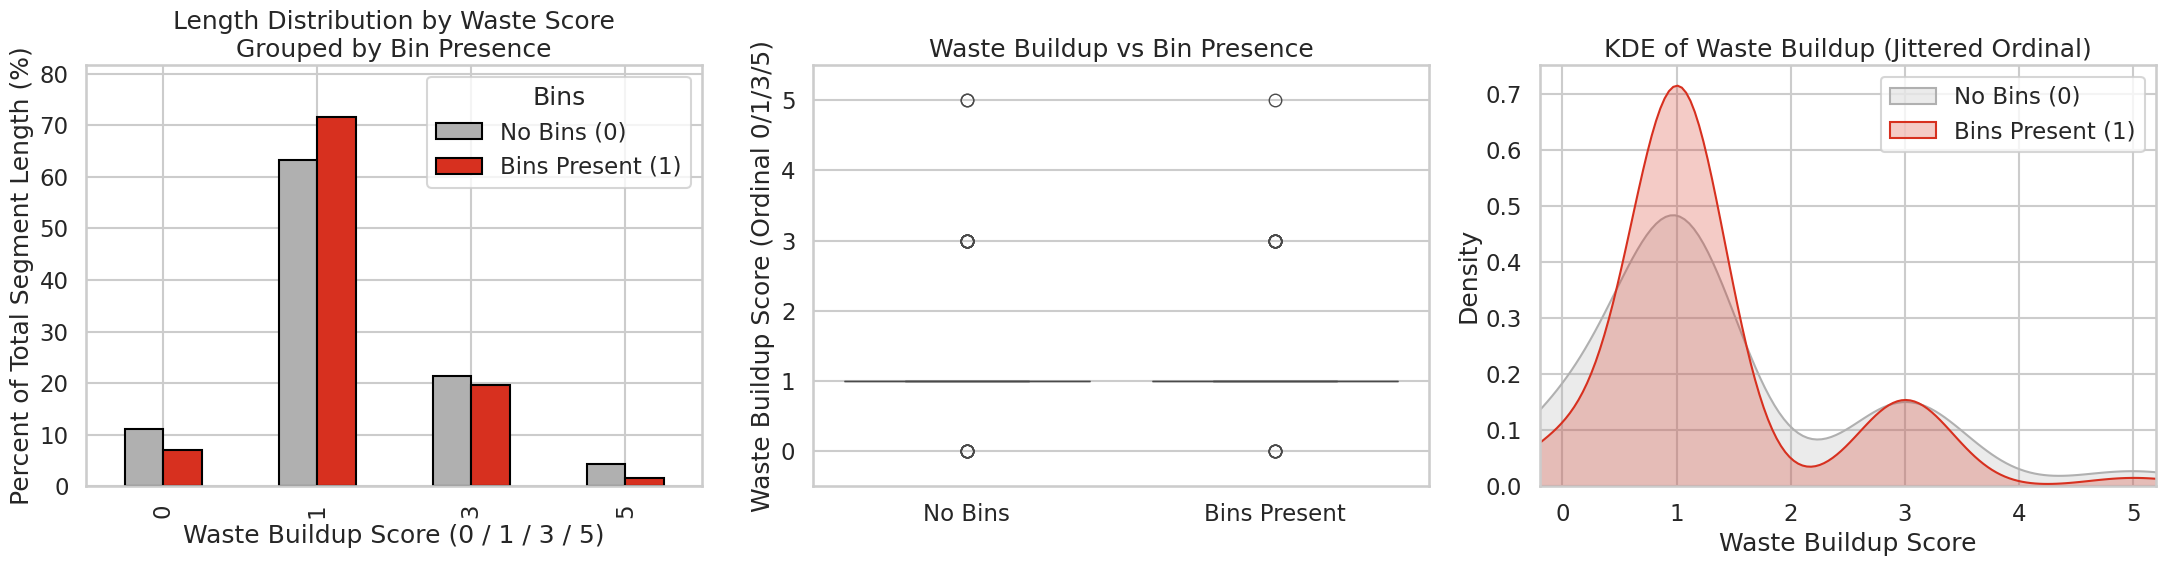

In [43]:
#FOR MAI HICH

sns.set(style="whitegrid", context="talk")

# -----------------------------
# 1. PREPARE ORDERED CATEGORIES
# -----------------------------
ordinal_vals = [0, 1, 3, 5]

# ensure binary column exists
df2['bins_present'] = (df2['trash_bins_per_200m'] > 0).astype(int)


mh_vol_length_bins = (
    df2.groupby(['bins_present', 'vol_waste'])['length_m']
      .sum()
      .unstack(fill_value=0)
      .reindex(columns=ordinal_vals)
)

mh_vol_percent_length_bins = (
    mh_vol_length_bins.div(mh_vol_length_bins.sum(axis=1), axis=0) * 100
).round(1)

# -----------------------------
# 3. CREATE FIGURE (3 PANELS)
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# ============================================================
# PANEL 1 — Bar Chart (Percent Length)
# ============================================================

mh_vol_percent_length_bins.T.plot(
    kind='bar',
    ax=axes[0],
    color=['#b0b0b0', '#d7301f'],  # grey = no bins, blue = bins present
    edgecolor='black'
)

axes[0].set_title("Length Distribution by Waste Score\nGrouped by Bin Presence")
axes[0].set_xlabel("Waste Buildup Score (0 / 1 / 3 / 5)")
axes[0].set_ylabel("Percent of Total Segment Length (%)")
axes[0].legend(["No Bins (0)", "Bins Present (1)"], title="Bins")
axes[0].set_ylim(0, mh_vol_percent_length_bins.max().max() + 10)

# ============================================================
# PANEL 2 — Boxplot (Ordinal vs Binary)
# ============================================================

sns.boxplot(
    data=df2,
    x=df2['bins_present'].map({0: "No Bins", 1: "Bins Present"}),
    y='vol_waste',
    ax=axes[1],
    palette=["#b0b0b0", "#d7301f"]
)

axes[1].set_title("Waste Buildup vs Bin Presence")
axes[1].set_xlabel("")
axes[1].set_ylabel("Waste Buildup Score (Ordinal 0/1/3/5)")
axes[1].set_ylim(-0.5, 5.5)

# ============================================================
# PANEL 3 — KDE (with jitter)
# ============================================================

df2['vol_waste_jitter'] = df2['vol_waste'] + np.random.uniform(-0.05, 0.05, size=len(df2))

sns.kdeplot(
    data=df2[df2['bins_present'] == 0],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#b0b0b0',
    label="No Bins (0)"
)

sns.kdeplot(
    data=df2[df2['bins_present'] == 1],
    x='vol_waste_jitter',
    ax=axes[2],
    fill=True,
    color='#d7301f',
    label="Bins Present (1)"
)

axes[2].set_title("KDE of Waste Buildup (Jittered Ordinal)")
axes[2].set_xlabel("Waste Buildup Score")
axes[2].set_xlim(-0.2, 5.2)
axes[2].legend()

plt.tight_layout()
plt.show()


In [44]:
# MAI HICH Mann–Whitney U Test for Waste Volume by Bin Presence
# create binary indicator for bin presence
df2['bins_present'] = (df2['trash_bins_per_200m'] > 0).astype(int)

mh_bins0 = df2[df2['bins_present'] == 0]['vol_waste']
mh_bins1 = df2[df2['bins_present'] == 1]['vol_waste']

stat, p = mannwhitneyu(mh_bins0, mh_bins1, alternative='two-sided')

print("Mann–Whitney U:", stat)
print("p-value:", p)

# STATISTICAL INTERPRETATION (based on actual result: p = 0.9707):
#   p = 0.9707 → above the 0.05 threshold.
#   There is no statistically meaningful difference in waste severity between segments with bins and those without bins.

Mann–Whitney U: 1711.0
p-value: 0.9707984463160578
